## Burn Cube C3 Sandbox (AWS) Validation Notebook

This script shows the workflow to evaluate a burn extent map against independent fire perimeter polygon data. The workflow provides a visual comparison as well as False Positive and True Positive statistics that can be used to construct Receiver Pperating Characteristic (ROC) curves.

The output comes from `Burn Cube C3 Sandbox (AWS) Notebook`

In [1]:
import xarray as xr
import numpy as np
import Burn_Cube_C3_validation_utils as val
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sev = xr.open_dataset('BurnMapping_SirIvan_2017_C3_AWS_sandbox-small.nc')

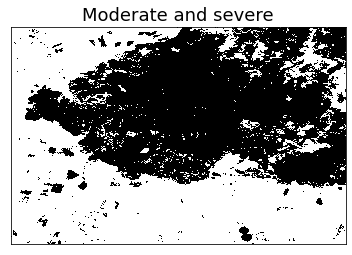

In [3]:
Burnpixel = val.burnpixel_masking(sev,'Moderate') # mask the burnt area with "Medium" burnt area
cax=Burnpixel.plot.imshow(cmap='binary',add_colorbar=False)
cax.axes.set_title('Moderate and severe',fontsize=18)
cax.axes.get_xaxis().set_visible(False)
cax.axes.get_yaxis().set_visible(False)

fire started at:  NaT


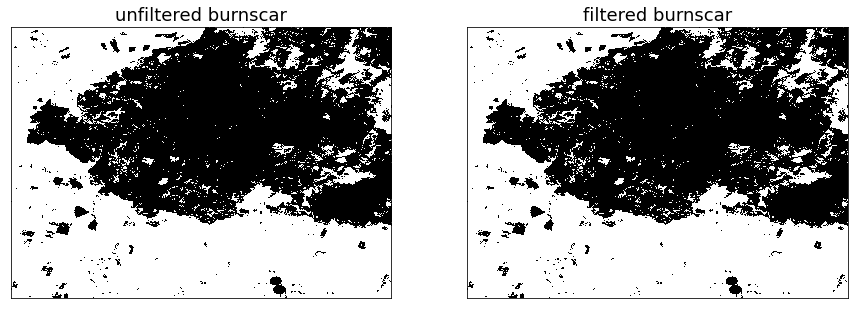

In [4]:
#use the date with maximum number of burnt area as the fire date
values, counts = np.unique(sev.StartDate, return_counts=True)
print('fire started at: ',values[counts==np.max(counts)].astype('datetime64[ns]')[0])
firedate=values[counts==np.max(counts)]
#filtered out any change happend one month before and one month after the fire
start = (firedate.astype('datetime64[ns]')-np.datetime64(1, 'M')).astype('datetime64[ns]')
end = (firedate.astype('datetime64[ns]')-np.datetime64(-1, 'M')).astype('datetime64[ns]')
row,col=np.where((sev.StartDate.data.astype('datetime64[ns]')<start)|(sev.StartDate.data.astype('datetime64[ns]')>end)) 

fig,axes=plt.subplots(ncols=2,figsize=[15,5])
cax1=Burnpixel.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
cax1.axes.set_title('unfiltered burnscar',fontsize=18)
cax1.axes.get_xaxis().set_visible(False)
cax1.axes.get_yaxis().set_visible(False)

Burnpixel.data[row,col]=0
cax2=Burnpixel.plot.imshow(cmap='binary',add_colorbar=False)
cax2.axes.set_title('filtered burnscar',fontsize=18)
cax2.axes.get_xaxis().set_visible(False)
cax2.axes.get_yaxis().set_visible(False)

ANUWALD.TreeCover.25m.2016.nc


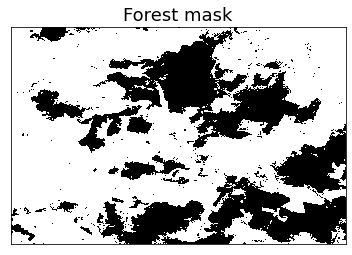

In [5]:
#reminder: forest mask has to be derived from the tree cover data before fire occured
mask=val.treecover_masking(year=2016,data=Burnpixel,prctg=60) 
cax1=mask.ForestMask.plot.imshow(cmap='binary',add_colorbar=False)
cax1.axes.set_title('Forest mask',fontsize=18)
cax1.axes.get_xaxis().set_visible(False)
cax1.axes.get_yaxis().set_visible(False)

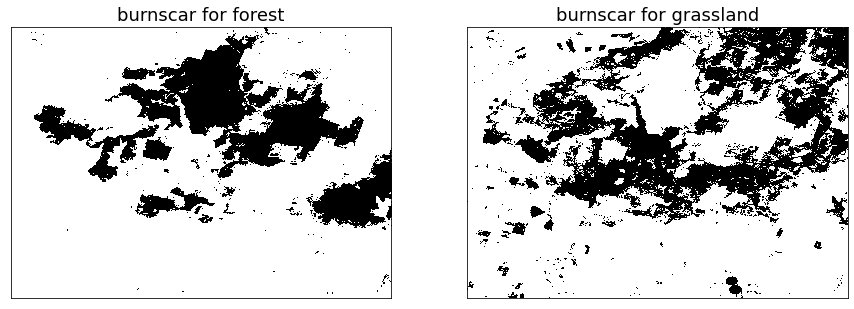

In [6]:
ForestBurned = Burnpixel*mask.ForestMask # burned pixel found in the forest area
NoneForestBurned = Burnpixel*mask.NoneForestMask # burned pixel found in the non-forest area
fig,axes=plt.subplots(ncols=2,figsize=[15,5])
cax1=ForestBurned.plot.imshow(ax=axes[0],cmap='binary',add_colorbar=False)
cax1.axes.set_title('burnscar for forest',fontsize=18)
cax1.axes.get_xaxis().set_visible(False)
cax1.axes.get_yaxis().set_visible(False)
cax2=NoneForestBurned.plot.imshow(ax=axes[1],cmap='binary',add_colorbar=False)
cax2.axes.set_title('burnscar for grassland',fontsize=18)
cax2.axes.get_xaxis().set_visible(False)
cax2.axes.get_yaxis().set_visible(False)

In [7]:
ValidationMask=val.CreateValidatedBurnMask(Burnpixel,State='NSW', Validation_period=("2017-01-01","2017-12-31"))
ValidationMask = ValidationMask.sum('time') #create one mask with all the burned area

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


The false positive and truth positive rate for forest burnt area: 0.009, 0.971
The false positive and truth positive rate for non-forest burnt area: 0.059, 0.766


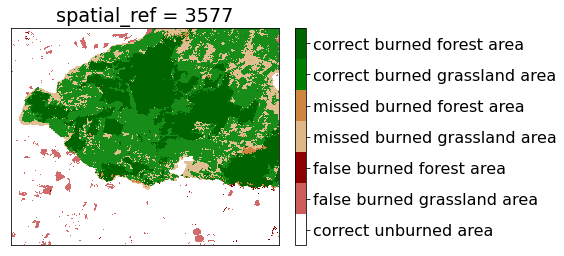

In [8]:
a,b = val.validate_forest_grass(Test_Array = Burnpixel, Validated_Array = ValidationMask,Mask = mask, plot=True)
print('The false positive and truth positive rate for forest burnt area: %.3f, %.3f' %(a[0],a[1]))
print('The false positive and truth positive rate for non-forest burnt area: %.3f, %.3f' %(b[0],b[1]))